# Facial expression Recognition using 3 models (CNN, ANN, CNN+RF) and analysis on the accuracy or performance of each model

##### Importing the necessary libraries

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import scipy.misc
import scipy
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator
from skimage.transform import resize
from keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D,MaxPooling1D
from keras.layers import Activation,Dropout,Flatten,BatchNormalization
from keras.models import Sequential
from keras.utils import np_utils
import tensorflow as tf
import keras
from keras import backend as K
K.image_data_format()
from keras import applications
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adadelta
from keras.utils import np_utils
from keras.regularizers import l2
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import csv
import scipy.misc
import scipy
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator
from tkinter import *
import cv2
from tqdm import tqdm
import os
from IPython import display
import time
import matplotlib.pyplot as plt
from keras.models import load_model, Model

 ##### loading dataset CK+48 (available on Kaggle)

In [2]:
os.listdir(r"C:/Users/ponny/OneDrive - Cal State Fullerton/Classes/2022 Fall/CPSC 481-04 AI/Project/second try/CK+48")

['anger', 'fear', 'happy', 'sadness', 'surprise']

In [3]:
def load_file():
    dir_ = r"C:\Users\ponny\OneDrive - Cal State Fullerton\Classes\2022 Fall\CPSC 481-04 AI\Project\second try\CK+48"
    dir_list = os.listdir(dir_)
    image_list = []
    emotions = []
    labels = []
    l = 0
    for em in dir_list:
        label = os.listdir(dir_ + '/' + em)
        for img in label:
                input_img = cv2.imread(dir_ + '/' + em + '/' + img)
                input_img = cv2.resize(input_img, (96,96))
                image_list.append(input_img)
                labels.append(l)
        emotions.append(em)
        l = l+1
    return image_list, labels, emotions

    

In [4]:
img_list, labels, emotions = load_file()

the images in the dataset correspond to one of the following 5 emotions 

In [5]:
emotions

['anger', 'fear', 'happy', 'sadness', 'surprise']

In [6]:
label = np.array(labels)
count = np.bincount(label)
for i in range(0,5):
    print(i, "=", count[i] )


0 = 135
1 = 75
2 = 207
3 = 84
4 = 249


In [7]:
img_data = np.array(img_list)
img_data.shape


(750, 96, 96, 3)

In [8]:
num_classes = 5 #since there are 5 total emotions

##### Splitting the dataset for training and testing in the ratio of 80:20

In [9]:
from sklearn.model_selection import train_test_split
y= keras.utils.to_categorical(labels, num_classes)
x_train, x_test, y_train, y_test = train_test_split(img_data, y, test_size=0.2)

In [10]:
data_gen_with_aug = ImageDataGenerator(rescale=1/255, horizontal_flip=True,width_shift_range=0.1, height_shift_range=0.1)

In [11]:
data_gen_no_aug = ImageDataGenerator(rescale=1/255)
train_generator = data_gen_with_aug.flow(x_train, y_train)
validation_generator = data_gen_with_aug.flow(x_test, y_test)

##### Functions for encoding label, for loading images

In [12]:
def encode_y(y):
    y_encode =[]
    
    n = len(y)
    for i in range(0,n):
        for j in range(0,5):
            if y[i][j] == 1:
                clas = j
                continue
        y_encode.append(clas)
    return y_encode

    
    

In [13]:
def load_images(image_data):
    images = []
    for sample in image_data:
        dim =(96,96)
        image = sample[:, :, 0]
        resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
        image = np.reshape(resized, (96,96,1))
        images.append(image)
    images=np.array(images)/255
    return images


In [14]:
# NO NEED I GUESS
def plot_sample(image, keypoint, axis, title):
    image = image.reshape(96,96)
    axis.imshow(image, cmap='Accent')
    axis.scatter(keypoint[::2], keypoint[1::2], marker='x', s=20)
    plt.title(title)

##### to convert label value to corresponding text denoting the emotion

In [15]:
label_to_text= {0:'anger', 1:'fear', 2:'happy', 3:'sadness', 4:'surprise'}

## CNN (Convolutional Neural Network)

##### model creation

In [16]:
input_shape = (96, 96, 3)
model = Sequential()
model.add(Conv2D(32,kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(Dropout(0.35))
model.add(Conv2D(64,(3, 3),activation='relu'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2),padding = 'same'))
model.add(Conv2D(128,(3, 3), activation='relu'))
model.add(Conv2D(256,(3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.35))
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.35))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam',metrics=['accuracy'],loss='categorical_crossentropy')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 dropout (Dropout)           (None, 94, 94, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 92, 92, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 44, 44, 128)       73856     
                                                        

##### Training the model using fit()

In [18]:
history1 = model.fit(
    x_train, y_train,
    validation_data = (x_test,y_test),
    batch_size=64,
    verbose=1,
    epochs=30
)

Epoch 1/30
10/10 [==============================] - 45s 4s/step - loss: 1.7473 - accuracy: 0.3350 - val_loss: 6.6948 - val_accuracy: 0.1667
Epoch 2/30
10/10 [==============================] - 39s 4s/step - loss: 1.3936 - accuracy: 0.4917 - val_loss: 8.1072 - val_accuracy: 0.1933
Epoch 3/30
10/10 [==============================] - 39s 4s/step - loss: 1.1862 - accuracy: 0.5600 - val_loss: 4.6720 - val_accuracy: 0.2133
Epoch 4/30
10/10 [==============================] - 37s 4s/step - loss: 1.0279 - accuracy: 0.6200 - val_loss: 2.5581 - val_accuracy: 0.4133
Epoch 5/30
10/10 [==============================] - 39s 4s/step - loss: 0.8952 - accuracy: 0.6650 - val_loss: 1.3811 - val_accuracy: 0.4333
Epoch 6/30
10/10 [==============================] - 38s 4s/step - loss: 0.7586 - accuracy: 0.7217 - val_loss: 1.2623 - val_accuracy: 0.4800
Epoch 7/30
10/10 [==============================] - 39s 4s/step - loss: 0.6618 - accuracy: 0.7433 - val_loss: 36.8679 - val_accuracy: 0.3200
Epoch 8/30
10/10 [=

##### Plotting the accuracy and loss during training and valiation 

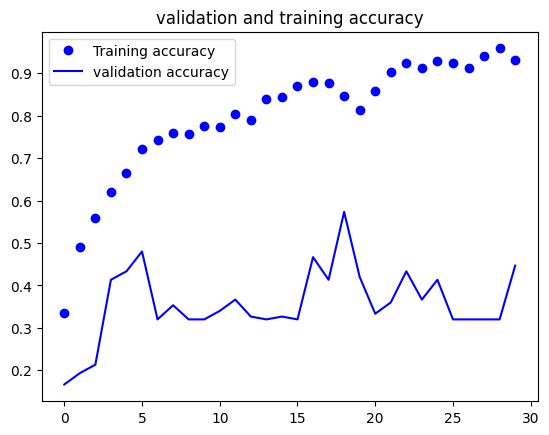

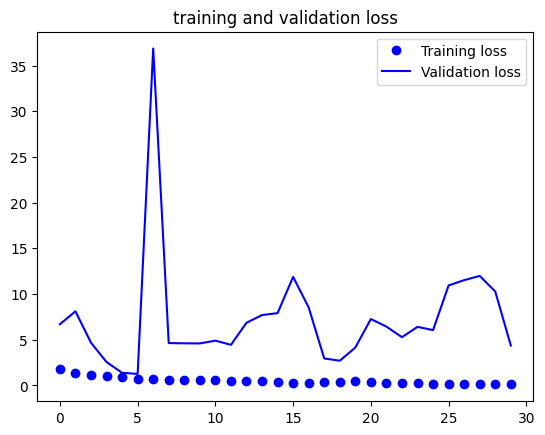

In [19]:
acc1 =history1.history['accuracy']
val_acc1=history1.history['val_accuracy']
loss_1=history1.history['loss']
val_los1=history1.history['val_loss']

epochs1=range(len(acc1))

plt.plot(epochs1, acc1, 'bo', label='Training accuracy')
plt.plot(epochs1, val_acc1, 'b', label='validation accuracy')
plt.legend()
plt.title('validation and training accuracy')

plt.figure()

plt.plot(epochs1, loss_1, 'bo', label='Training loss')
plt.plot(epochs1, val_los1, 'b', label='Validation loss')
plt.plot(figsize=(10,5))
plt.title('training and validation loss')
plt.legend()

plt.show()

##### Detecting the emotion from an image - output after training the model

5/5 [==============================] - 2s 401ms/step
actual label is  surprise
predicted label is  surprise


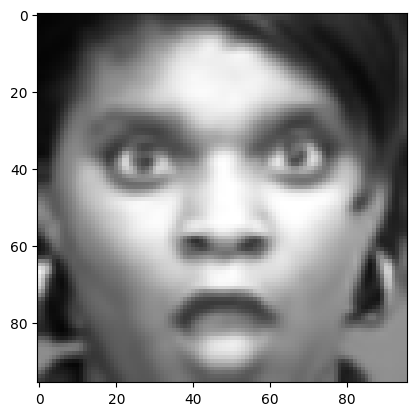

In [22]:
y_pred1 = model.predict(x_test)
print(f'actual label is ', (label_to_text[np.argmax(y_test[0])]))
print(f'predicted label is ', (label_to_text[np.argmax(y_pred1[0])]))
plt.imshow(x_test[0])
plt.show()

## ANN (Artifcial Neural Network)

##### model creation

In [23]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (5,5), activation='relu', input_shape=(96,96,3)),
    tf.keras.layers.Conv2D(64, (5,5), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(64, (5,5), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')])

In [24]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 92, 92, 64)        4864      
                                                                 
 conv2d_5 (Conv2D)           (None, 88, 88, 64)        102464    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 44, 44, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 42, 42, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 19, 19, 128)      

In [25]:
model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

##### training the model using fit()

In [26]:
history = model2.fit(train_generator, epochs=45, validation_data=validation_generator, verbose=1, batch_size=64)


Epoch 1/45
19/19 [==============================] - 46s 2s/step - loss: 0.1552 - accuracy: 0.3000 - val_loss: 0.1519 - val_accuracy: 0.3200
Epoch 2/45
19/19 [==============================] - 40s 2s/step - loss: 0.1507 - accuracy: 0.3350 - val_loss: 0.1557 - val_accuracy: 0.3200
Epoch 3/45
19/19 [==============================] - 42s 2s/step - loss: 0.1525 - accuracy: 0.3350 - val_loss: 0.1541 - val_accuracy: 0.3200
Epoch 4/45
19/19 [==============================] - 43s 2s/step - loss: 0.1527 - accuracy: 0.2900 - val_loss: 0.1529 - val_accuracy: 0.3200
Epoch 5/45
19/19 [==============================] - 41s 2s/step - loss: 0.1526 - accuracy: 0.3100 - val_loss: 0.1535 - val_accuracy: 0.3200
Epoch 6/45
19/19 [==============================] - 41s 2s/step - loss: 0.1523 - accuracy: 0.3350 - val_loss: 0.1531 - val_accuracy: 0.3200
Epoch 7/45
19/19 [==============================] - 42s 2s/step - loss: 0.1515 - accuracy: 0.3350 - val_loss: 0.1532 - val_accuracy: 0.3200
Epoch 8/45
19/19 [==

##### Plotting the accuracy and loss during training and validation

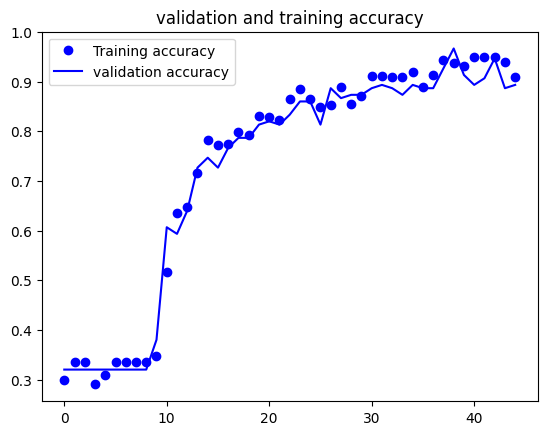

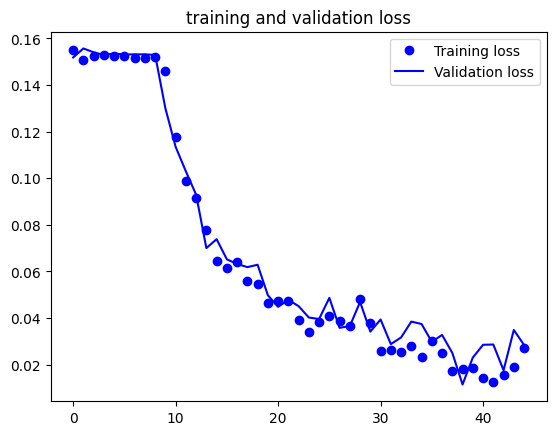

In [27]:
acc =history.history['accuracy']
val_acc=history.history['val_accuracy']
loss_=history.history['loss']
val_los=history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='validation accuracy')
plt.legend()
plt.title('validation and training accuracy')

plt.figure()

plt.plot(epochs, loss_, 'bo', label='Training loss')
plt.plot(epochs, val_los, 'b', label='Validation loss')
plt.plot(figsize=(10,5))
plt.title('training and validation loss')
plt.legend()

plt.show()


In [28]:
y_pred=model2.predict(x_test)
y_pred=encode_y(y_pred)

5/5 [==============================] - 2s 415ms/step


##### Evaluation metrics like accuracy, precision, recall, f1-score is shown below

In [29]:

from sklearn.metrics import accuracy_score
accuracy_score(encode_y(y_test), y_pred)

0.84

In [30]:
from sklearn.metrics import classification_report
print(classification_report(encode_y(y_test), y_pred))

              precision    recall  f1-score   support

           0       1.00      0.36      0.53        25
           1       0.55      0.89      0.68        19
           2       0.93      1.00      0.97        42
           3       0.77      0.62      0.69        16
           4       0.92      1.00      0.96        48

    accuracy                           0.84       150
   macro avg       0.83      0.78      0.76       150
weighted avg       0.87      0.84      0.83       150



##### 20 Pictures with emotion detected and actual emotion displayed on loop 

actual label is  anger
predicted label is  happy


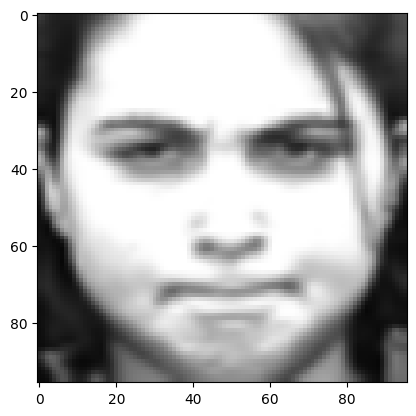

In [41]:
from IPython import display
import time
import matplotlib.pyplot as plt
for k in range(20):
    print(f'actual label is ', (label_to_text[np.argmax(y_test[k])]))
    print(f'predicted label is ', (label_to_text[y_pred[k]]))
    plt.imshow(x_test[k])
    plt.show()
    time.sleep(3)
    display.clear_output(wait=True)

## CNN + RF (Random Forest)

##### Building the Model

In [32]:
model3= tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (5,5), activation='relu', input_shape=(96,96,1)),
    tf.keras.layers.Conv2D(64, (5,5), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(64, (5,5), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten()
    
])

In [33]:
x_train_ext=model3.predict(load_images(x_train))
x_train_ext=np.squeeze(x_train_ext)

19/19 [==============================] - 11s 571ms/step


In [34]:
x_train_ext.shape

(600, 20736)

##### using Random Forest classifier model for training on x_train_ext ( data from CNN model)

In [35]:
from sklearn.ensemble import RandomForestClassifier
forest=RandomForestClassifier()
history3 =forest.fit(x_train_ext, encode_y(y_train))

In [36]:
x_test_ext = model3.predict(load_images(x_test))

5/5 [==============================] - 3s 518ms/step


In [37]:
y_pred2=forest.predict(x_test_ext)

##### Evaluation metrics like accuracy score, precision, recall, f1-score

In [38]:
accuracy_score(encode_y(y_test), y_pred2)

0.9866666666666667

In [39]:
print(classification_report(encode_y(y_test), y_pred2))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        25
           1       1.00      0.95      0.97        19
           2       1.00      1.00      1.00        42
           3       1.00      0.94      0.97        16
           4       1.00      1.00      1.00        48

    accuracy                           0.99       150
   macro avg       0.99      0.98      0.98       150
weighted avg       0.99      0.99      0.99       150



##### 20 Pictures with emotion detected and actual emotion displayed on loop

actual label is  anger
predicted label is  anger


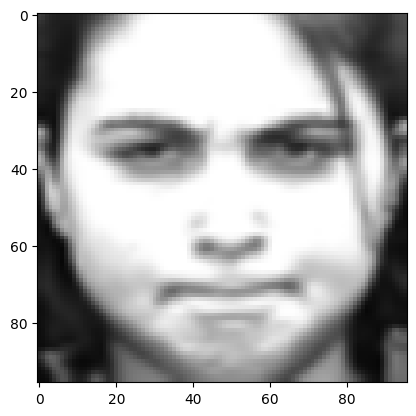

In [42]:
from IPython import display
import time
import matplotlib.pyplot as plt
for k in range(20):
    print(f'actual label is ', (label_to_text[np.argmax(y_test[k])]))
    print(f'predicted label is ', (label_to_text[y_pred2[k]]))
    plt.imshow(x_test[k])
    plt.show()
    time.sleep(3)
    display.clear_output(wait=True)

## CNN + RF has the better accuracy of 98.6% compared to ANN (84%) and CNN (50%)

After researching it could be found that CNN model works best for facial emotion recognition. However, in our case CNN model
couldn't work as expected. Tuning the training parameters for CNN might imrpove the accuracy, but it needs a GPU for faster processing since training in my computer takes too long even for the parameters given now.